In [1]:
from run import *
import time
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
viz = None

In [4]:
reduced=True
if reduced:
    # q_i= np.deg2rad([90., 0.])
    q_i= np.deg2rad([-90., 40.]) #EASY
    q_i= np.deg2rad([-170., 0.]) #NOT EASY
    q_g= np.deg2rad([-79., 64.])
else:
    q_i = np.array([1., -1.5, 2.1, -.5, -.5, 0])
    q_g = np.array([3., -1., 1, -.5, -.5, 0])
robot = initialize_problem(reduced=reduced)
if viz is None:
    viz = MeshcatVisualizer(robot)
add_special_locations(
    robot,
    viz,
    [
        (q_i, "initial", "red"),
        (q_g, "goal", "green")
    ]
)
system = solve(robot, viz, q_i, q_g, reduced=reduced)



In [73]:
system.reset()
rrt = RRT(
    system,
    N_bias=20,
    l_min=0.2,
    l_max=0.5,
    steer_delta=0.1,
)
eps_final = .1
def validation(key):
    vec = robot.framePlacement(key, 22).translation - robot.framePlacement(q_g, 22).translation
    return (float(np.linalg.norm(vec)) < eps_final)

rrt.solve(q_i, validation, qg=q_g)
final_path = rrt.get_path(q_g)
for q in final_path:
    assert not(system.is_colliding(q))

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 240/1000000 [00:09<10:43:57, 25.88it/s]


In [75]:
system.display_motion(final_path)

# Visualization of the RRT trajectory in the configuration space

In [ ]:
# Sample the collision grid in a uniform fashion, this could take a while
step_size = 0.1
q1_values = np.arange(-np.pi, np.pi, step_size)
q2_values = np.arange(-np.pi, np.pi, step_size)[::-1] # +pi is at the top of the image

# Initialize a matrix to store the results
results = np.zeros((len(q1_values), len(q2_values)))

# Evaluate collisionDistance for each point in the grid
for i, q2 in enumerate(q2_values):
    for j, q1 in enumerate(q1_values):
        results[i, j] = system.is_colliding(np.array([q1, q2]))

(-3.141592653589793, 3.141592653589793, -3.141592653589793, 3.141592653589793)

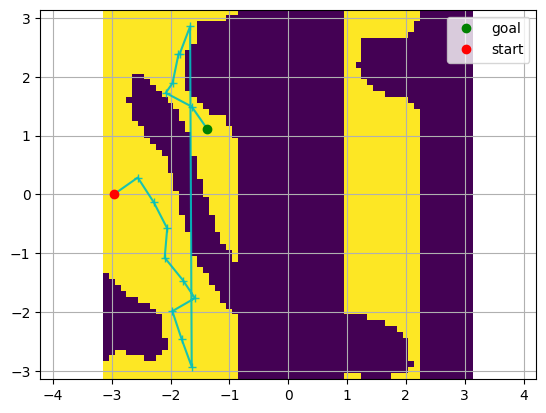

In [85]:
import matplotlib.pyplot as plt
final_path = rrt.get_path(q_g).copy()
final_path[final_path > np.pi] = 2 * np.pi - final_path[final_path > np.pi]
final_path[final_path < -np.pi] = 2 * np.pi + final_path[final_path < -np.pi]

plt.plot(final_path[:, 0], final_path[:, 1], "c-+", alpha=0.9)
plt.plot(final_path[-1, 0], final_path[-1, 1], "go", label="goal")
plt.plot(final_path[0, 0], final_path[0, 1], "ro", label="start")
plt.grid()
plt.legend()
obstacle_viz = 1-results.copy()
# obstacle_viz[obstacle_viz==0.] = np.nan
plt.imshow(obstacle_viz, extent=[-np.pi, np.pi, -np.pi, np.pi])
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.axis("equal")